In [1]:
%load_ext autoreload
%autoreload 2

## Importing & Setting Style

In [2]:
# imports
import os, sys, string, re, itertools, random

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

import pandas as pd
import numpy as np

import nltk

from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# # updates for nltk helper packages
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

from src import visualizations as vz
from src import functions as fn

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')
pd.options.display.max_rows = 300

## Sanity Check

In [3]:
!pwd

/Users/dsbox/Documents/Flatiron/p_4_project/nlp_sentiment_project/notebooks/exploratory


## Importing Data & Checking Info

In [4]:
path = path = os.path.join(gparent, 'data/raw',\
                           'judge-1377884607_tweet_product_company.csv')
df = pd.read_csv(path, encoding='unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## Checking Null Tweet

In [6]:
df[df['tweet_text'].isnull()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,NaN,No emotion toward brand or product


## Dropping Null Tweet

In [7]:
df.drop(6, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## Renaming Columns
The original names are a bit unwieldy.

In [9]:
rename_dict = {'tweet_text': 'tweet', 
               'emotion_in_tweet_is_directed_at': 'brand_product', 
               'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion' }
df.rename(columns=rename_dict, inplace=True)
df.head()

,tweet,brand_product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Checking Brand/Product Unique Values

In [10]:
df.brand_product.unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

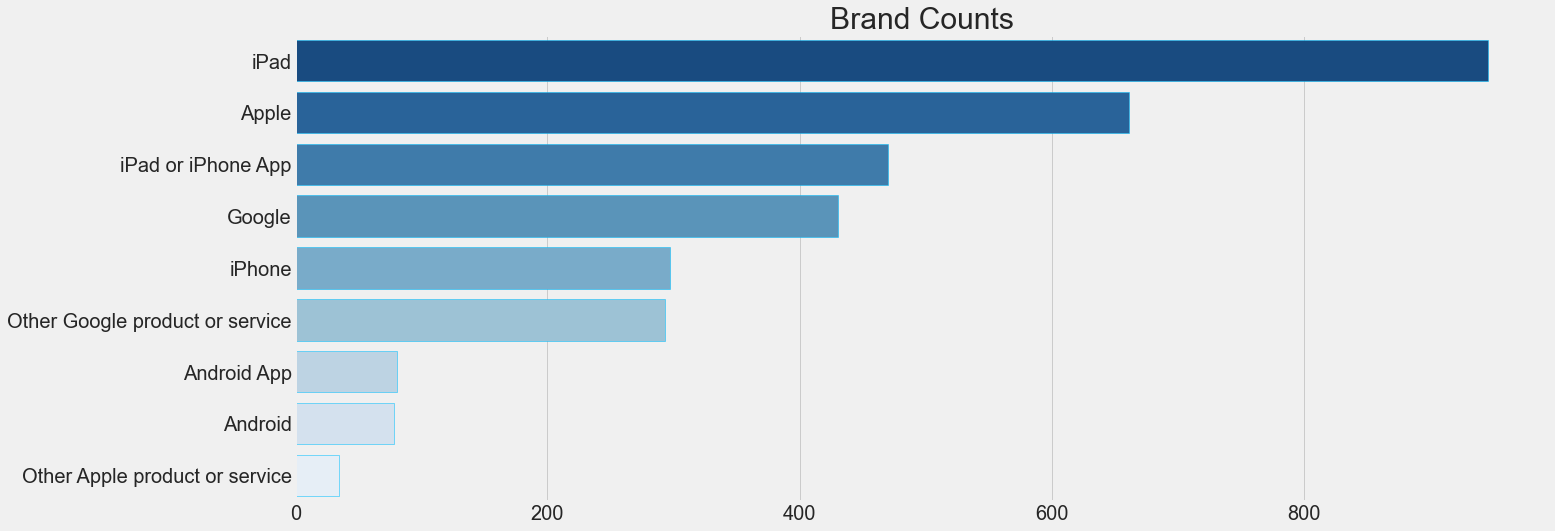

In [11]:
vz.brand_counts(df)

In [12]:
df.brand_product.value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: brand_product, dtype: int64

In [13]:
df.brand_product.isna().sum()

5801

## Checking Emotion Unique Values

In [14]:
df.emotion.unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

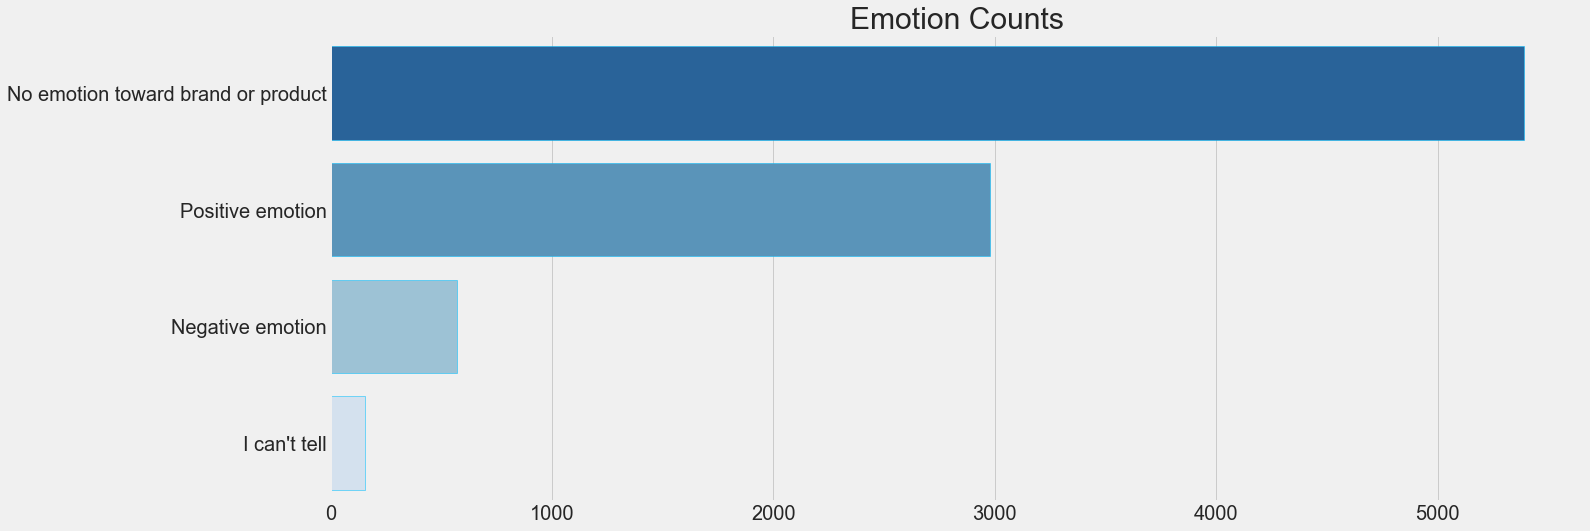

In [15]:
vz.emotion_counts(df)

In [16]:
df.emotion.value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

## Checking Null Brands Data

In [17]:
null_brand_emotions = df[(df['brand_product'].isna()) &\
                        (df['emotion'] != 'No emotion toward brand or product')]

In [18]:
null_brand_emotions.head()

,tweet,brand_product,emotion
45,Hand-Held Û÷HoboÛª: Drafthouse launches Û÷H...,NaN,Positive emotion
63,Again? RT @mention Line at the Apple store is ...,NaN,Negative emotion
67,Boooo! RT @mention Flipboard is developing an ...,NaN,Negative emotion
89,Thanks to @mention for publishing the news of ...,NaN,I can't tell
101,ÛÏ@mention &quot;Apple has opened a pop-up st...,NaN,I can't tell


In [19]:
print(null_brand_emotions.tweet[45])

Hand-Held Û÷HoboÛª: Drafthouse launches Û÷Hobo With a ShotgunÛª iPhone app #SXSW {link}


In [20]:
print(null_brand_emotions.tweet[63])

Again? RT @mention Line at the Apple store is insane.. #sxsw


In [21]:
print(null_brand_emotions.tweet[67])

Boooo! RT @mention Flipboard is developing an iPhone version, not Android, says @mention #sxsw


In [22]:
null_brand_emotions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 45 to 9057
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          504 non-null    object
 1   brand_product  0 non-null      object
 2   emotion        504 non-null    object
dtypes: object(3)
memory usage: 35.8+ KB


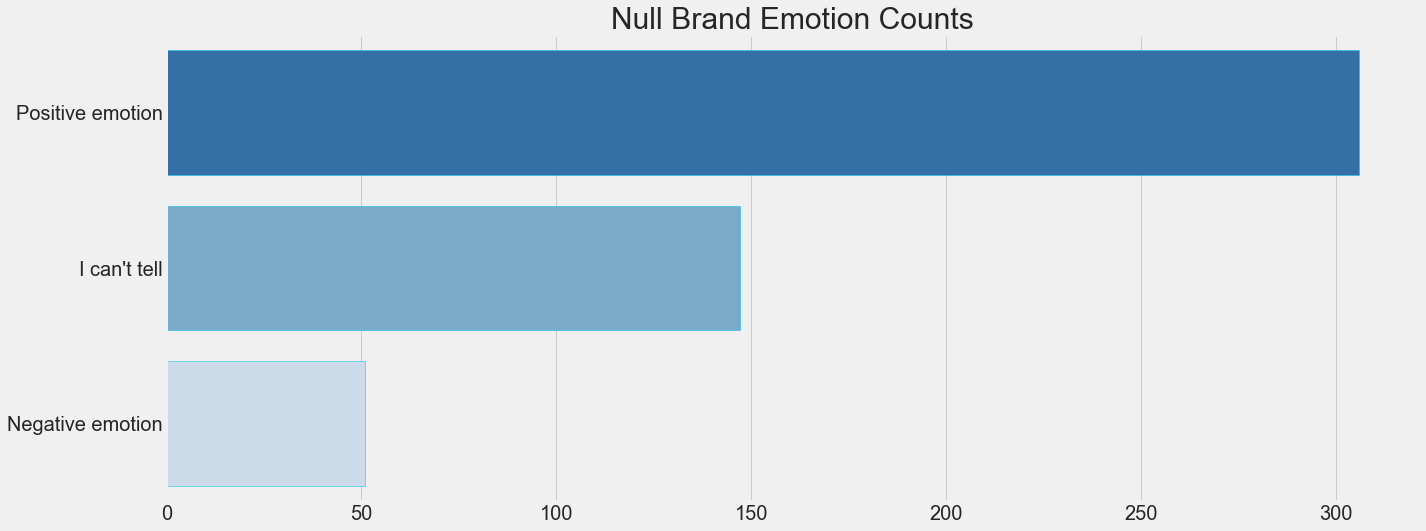

In [23]:
vz.null_brand_emotions(df)

## Setting `data` & `target`

In [24]:
df.isna().sum()

tweet               0
brand_product    5801
emotion             0
dtype: int64

In [25]:
df.tweet[0]

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

In [26]:
data = df['tweet']
target = df['emotion']

In [27]:
data.isna().sum()

0

In [28]:
len(data)

9092

In [29]:
len(data) == len(target)

True

## Testing Tokenizations

### Strategy: (stopwords, string.punctuation)

In [30]:
# removing stopwords & punx
processed_data = list(map(fn.tweet_tokens, data))

# making vocab set
vocabulary = fn.vocabulary(processed_data)

#### Checking Out Our Vocab

In [31]:
# checking number of words
len(vocabulary)

10533

In [32]:
# first 100 words
for i, val in enumerate(itertools.islice(vocabulary, 100)):
    print(val)

cheers
evangelist
ofåêhere
shrink
donuts
weasel
lovers
halfway
marissamayer
ws
rare
textbook
hits
re-shoot
prototype
comparison
html5
evil
opinion
omgz
elegant
chevysxsw
direction
existent
former
notepad
guards
ghost
-ness
jesus
schooling
billboard
high-five
soooooo
bottom
2.û
sxsw-google
providers
mophie
howard
assisted.
appolicious
gaming
loko
metaphors
offchain
irelay
hating
favorited
lovin
easeljs
sony
scott
hoodies
yep
recommendation
cartridge
picplz
sun
whiteboard
barging
perhaps
revolutionary
value
displaying
execs
torturous
curve
timberlake
gasps
aaron
dfw
x
letters
attracting
augcomm
banking
noteshelf
mom/ipad
circle.
scenes
extend
concentrate
atl
androidsxsw
cartel
ubersoc
wordpress
volt
felix
12:30pm
symphony
co-workers
askd
drink
yowza
boots
applefanatic
mustachepox
latte


In [33]:
# random 100 words
for i, val in enumerate(random.sample(vocabulary, 100)):
    print(val)

signals
silicon
stocked
powerpad
nih
existence
thewildernessdowntown.com
earlier
skewed
plixi.com/p/83323324
tipping
option
contradicting
adi
fascinated
winamp
a.m
rudy
1:1
ipadmadness
iun
consumerist
economy.
wkend
seatmate
syncing
digital
ù_¾´_
heartrate
schema
realizing
morning
orly
portion
geosocial
sadpanda
convience
print
formation
understand
succumb
ex
tsotchke
geeksrule
approaching
til
ft
impactdashboard
owners
ill
atv
fandango
retreat
correct
attendence
longhorn
smells
policy
si
nasty
withdrawal
50-60
yall
75-80
alcoholics
earbud
1/4
toy
feeding
spend
designing
wolfram
personalized
nice
regularly
eod
drinking
whetherapple
laptop+charger
disney
wifi-only
degrading
gr2l2
tdg
fans
viewing
followed
usurped
0310apple
neck
painfully
wipe-
beat
squarespace
rhapsody/echo
pecan
wth
topic
lobbying
here.


### Strategy: (Regex: r'[a-zA-Z0-9]+')

In [34]:
# removing stopwords & punx
processed_data = list(map(fn.re_tokens, data))

vocabulary_re = fn.vocabulary(processed_data)

#### Checking Out Our Vocab

In [35]:
# number of words
len(vocabulary_re)

9548

In [36]:
# first 100 words
for i, val in enumerate(itertools.islice(vocabulary_re, 100)):
    print(val)

cheers
evangelist
shrink
donuts
cannot
weasel
lovers
halfway
marissamayer
ws
rare
textbook
hits
prototype
comparison
html5
evil
opinion
omgz
elegant
chevysxsw
direction
existent
former
notepad
guards
ghost
jesus
schooling
billboard
soooooo
bottom
providers
pper
mophie
howard
appolicious
gaming
loko
metaphors
offchain
irelay
hating
favorited
lovin
easeljs
sony
scott
hoodies
yep
recommendation
cartridge
picplz
sun
whiteboard
barging
perhaps
revolutionary
value
displaying
execs
torturous
curve
timberlake
gasps
aaron
dfw
x
letters
attracting
augcomm
banking
noteshelf
scenes
extend
concentrate
atl
androidsxsw
cartel
ubersoc
wordpress
volt
felix
symphony
askd
drink
yowza
boots
applefanatic
mustachepox
latte
n22
overcome
accessible
quake
shang
workinprogress
killers
verpixelungsrecht
sold


In [37]:
# random 100 words
for i, val in enumerate(random.sample(vocabulary_re, 100)):
    print(val)

figure
view512
rely
marathon
2g
interviewing
drumroll
routing
expierence
air
pity
recorded
zation
creator
web3
stated
zelda
mappers
turkey
warwick
dream
sis
clip
notwinning
lady
many
pgi
recipe
addicted
deal
funny
upload
googling
come
musique
nfl
picture
band
quicker
college
passing
lock
er
wil
matter
hold
joy
cheapen
capitalism
deadline
ordered
feature
itun
scrub
sketching
kiddie
extensive
xml
pentagram
increase
fixed
tech
partied
puzzles
tummy
mash
tragedy
prepaid
triple
favorited
lenashaw
hundreds
existent
tchin
organically
bemyneighbor
speaker
trans
additional
successful
met
ughhhhh
key
btw
fado
make
empowering
offic
smack
ingredients
tops
charles
compact
sxswnfc
appy
response
hopefully
37
partial
employees
